# Scott Breitbach
## 21-May-2021
## DSC550, Week 9

# 9.3 Exercise: Neural Network Classifiers

## Step 2. Neural Network Classifier with Keras

Using the multi-label classifier dataset from earlier exercises (categorized-comments.jsonl in the reddit folder), fit a neural network classifier using Keras. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guideline. Report the accuracy, precision, recall, F1-score, and confusion matrix.

## Load Data Set

In [1]:
# Load libraries
import numpy as np
import jsonlines
import pandas as pd

# Set random seed
np.random.seed(42)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load JSON data into a list of dictionaries
data = []
with jsonlines.open('categorized-comments.jsonl') as reader:
    for obj in reader.iter(type=dict, skip_invalid=True):
        data.append(obj)

In [3]:
# Convert data to DataFrame
cat_comments_df = pd.DataFrame(data)
cat_comments_df.head()

,cat,txt
0,sports,Barely better than Gabbert? He was significant...
1,sports,Fuck the ducks and the Angels! But welcome to ...
2,sports,Should have drafted more WRs.\n\n- Matt Millen...
3,sports,[Done](https://i.imgur.com/2YZ90pm.jpg)
4,sports,No!! NOO!!!!!


## Preprocess Text

In [4]:
# Load libraries
import sys
import unicodedata
import re

from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.porter import PorterStemmer

In [5]:
# from nltk.tokenize import word_tokenize

# # from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# Create a copy of the data set to manipulate
df = cat_comments_df.copy()

In [7]:
# Create a dictionary of punctuation
punctuation_dict = dict.fromkeys(i for i in range(sys.maxunicode) 
                            if unicodedata.category(chr(i)).startswith('P'))
# Create a dictionary of stopwords
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

def cleanText(string):
    '''Processes string and returns cleaned up list of words'''
    
    # Convert to lowercase
    string = string.lower()
    
    # Remove URLs
    string = re.sub(r'http\S+', '', string)
    
    # Remove punctuation
    string = string.translate(punctuation_dict)
    
    # Remove newlines
    string = string.replace("\n", " ")
    
    # Remove stopwords
    string = [word for word in string.split() if word not in stopwords_dict]
    
    return string

In [8]:
# Clean up the text in the 'txt' column
df.txt = df.txt.apply(lambda string: cleanText(string))

Wall time: 7.35 s


In [9]:
%%time
# Apply PorterStemmer
porter = PorterStemmer()
df['txt_stems'] = df.txt.apply(lambda words: [porter.stem(word) for word in words])

Wall time: 2min 50s


In [10]:
%%time
# Join tokenized stem words into a string
df['txt_str'] = df.txt_stems.apply(lambda s: ' '.join(map(str, s)))

Wall time: 1.14 s


In [11]:
# Take a look at data set
df.head()

,cat,txt,txt_stems,txt_str
0,sports,"[barely, better, gabbert, significantly, bette...","[bare, better, gabbert, significantli, better,...",bare better gabbert significantli better year ...
1,sports,"[fuck, ducks, angels, welcome, new, niners, fans]","[fuck, duck, angel, welcom, new, niner, fan]",fuck duck angel welcom new niner fan
2,sports,"[drafted, wrs, matt, millen, probably]","[draft, wr, matt, millen, probabl]",draft wr matt millen probabl
3,sports,[done],[done],done
4,sports,[noo],[noo],noo


## Sample Data Set Into Equal-Sized Groups

In [12]:
# Group data by category
cat_group = df.groupby('cat', as_index=False, group_keys=False)

In [13]:
# Sample 25000 rows from each category
balancedDF = cat_group.apply(lambda s: s.sample(25000, replace=False))

In [14]:
# Verify counts of categories
balancedDF.cat.value_counts()

science_and_technology    25000
sports                    25000
video_games               25000
Name: cat, dtype: int64

# Prepare Text for Model-Building

In [15]:
# Load Libraries
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer

## Split Training and Testing Data

In [16]:
# Set the number of features we want
number_of_features = 5000

# Set up data and labels
X = balancedDF.txt_str
y = balancedDF.cat

# Train Test Split
data_train, data_test, target_vector_train, target_vector_test = train_test_split(X, y)

In [17]:
# Convert text data to one-hot encoded feature matrix
tokenizer = Tokenizer(num_words=number_of_features)
# tokenizer = Tokenizer(num_words=number_of_features, split=',', char_level=False)
tokenizer.fit_on_texts(X)
features_train = tokenizer.texts_to_matrix(data_train, mode="binary")
features_test = tokenizer.texts_to_matrix(data_test, mode="binary")

In [18]:
# Binarize target categories in a one-vs-all fashion
lb = LabelBinarizer()
lb.fit(y)
target_train = lb.transform(target_vector_train)
target_test = lb.transform(target_vector_test)

## Define Keras Model

In [19]:
# Load Libraries
from keras.models import Sequential
from keras import layers

In [20]:
# Start neural network
network = Sequential()

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=500,
                         activation="relu",
                         input_shape=(number_of_features,)))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=150, activation="relu"))

# Add fully connected layer with a softmax activation function
network.add(layers.Dense(units=3, activation="softmax"))

# Compile neural network
network.compile(loss="categorical_crossentropy", # Cross-entropy
                optimizer="rmsprop", # Root Mean Square Propagation
                metrics=["accuracy"]) # Accuracy performance metric

## Fit Training Data to Model

In [21]:
# Train neural network
history = network.fit(features_train, # Features
                      target_train, # Target
                      epochs=3, # Three epochs
                      verbose=1, # Some output
                      batch_size=50, # Number of observations per batch
                      validation_data=(features_test, target_test)) # Test data

Epoch 1/3
1125/1125 [==============================] - 23s 19ms/step - loss: 0.6945 - accuracy: 0.6783 - val_loss: 0.5742 - val_accuracy: 0.7392
Epoch 2/3
1125/1125 [==============================] - 20s 18ms/step - loss: 0.5155 - accuracy: 0.7660 - val_loss: 0.5621 - val_accuracy: 0.7461
Epoch 3/3
1125/1125 [==============================] - 19s 17ms/step - loss: 0.4709 - accuracy: 0.7878 - val_loss: 0.5808 - val_accuracy: 0.7449


## Visualize Training History

In [22]:
# Load libraries
import matplotlib.pyplot as plt

#### Loss history

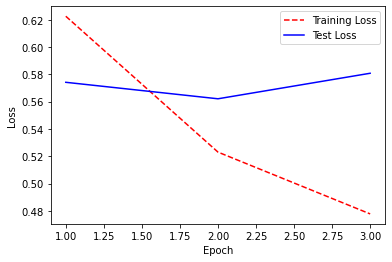

In [23]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

#### Accuracy history

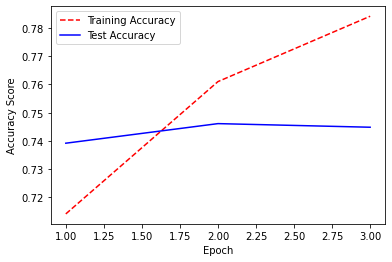

In [24]:
# Get training and test accuracy histories
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")

# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show();

## Predictions / Evaluation

In [25]:
# Load libraries
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
%%time
# Get predictions
predictions = network.predict(features_test)
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(target_test, axis=1)

Wall time: 1.81 s


### Confusion matrix

In [27]:
# Print confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[4952  525  855]
 [ 484 4510 1242]
 [ 660 1018 4504]]


#### Precision / Recall / F1 / Suport (Classification report)

In [28]:
# Print precision, recall, f1-score, and accuracy
cr = classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      6332
           1       0.75      0.72      0.73      6236
           2       0.68      0.73      0.70      6182

    accuracy                           0.74     18750
   macro avg       0.75      0.74      0.75     18750
weighted avg       0.75      0.74      0.75     18750



## Tuning the Neural Network

In [25]:
# Load Libraries
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


In [26]:
# Create function returning a compiled network
def create_network(optimizer="rmsprop"):
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=500,
                             activation="relu",
                             input_shape=(number_of_features,)))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=150, activation="relu"))

    # Add fully connected layer with a softmax activation function
    network.add(layers.Dense(units=3, activation="softmax"))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer=optimizer, # Root Mean Square Propagation
#                     optimizer="rmsprop", # Root Mean Square Propagation
                    metrics=["accuracy"]) # Accuracy performance metric

    # Return compiled network
    return network

In [ ]:
%%time
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, verbose=0)

# Create hyperparameter space 
## Round 1: 3, 50, 'adam' were best
## Round 2: 5, 75, 'rmsprop' were best
## Round 3: 3, 50, 'rmsprop' were best
epochs =  [3, 4, 5]      #1[1,  3, 10] #2[ 1,  3,  5] #3[3, 5, 7]
batches = [50, 60, 75]  #1[5, 15, 50] #2[30, 50, 75] ##[50, 75, 100]
optimizers = ["rmsprop", "adam"]

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)

# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)

# Fit grid search
grid_result = grid.fit(features_train, # Features
                      target_train, # Target
#                       epochs=epochs, # Three epochs
                      verbose=1, # Some output
#                       batch_size=batches, # Number of observations per batch
                      validation_data=(features_test, target_test)) # Test data

In [ ]:
# View hyperparameters of best neural network
grid_result.best_params_

In [29]:
from win32com.client import Dispatch
speak = Dispatch("SAPI.SpVoice").Speak

In [30]:
speak("modeling complete")

1